Cài đặt các thư viện cần thiết

In [15]:
!pip install statsmodels

In [1]:
!pip uninstall numpy
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.

Đọc dữ liệu và chuẩn bị dữ liệu

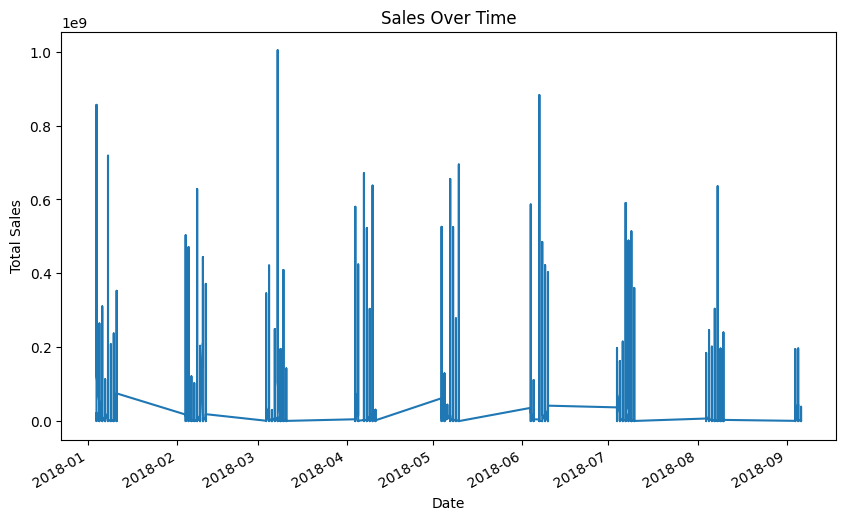

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import timedelta

# Load data
train_df = pd.read_csv("train.csv", parse_dates=["date"])
valid_df = pd.read_csv("validation.csv", parse_dates=["date"])
test_df = pd.read_csv("test.csv", parse_dates=["date"])

# Chuyển đổi cột date thành datetime
train_df['date'] = pd.to_datetime(train_df['date'])
valid_df['date'] = pd.to_datetime(valid_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Chọn chỉ cột 'total_sales' để xây dựng mô hình ARIMA
train_sales = train_df[['date', 'total_sales']].set_index('date')
valid_sales = valid_df[['date', 'total_sales']].set_index('date')
test_sales = test_df[['date', 'total_sales']].set_index('date')

# Kiểm tra xu hướng doanh thu theo thời gian
train_sales['total_sales'].plot(figsize=(10, 6))
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

Xây dựng mô hình ARIMA

In [17]:
# Huấn luyện mô hình ARIMA
# p: độ trễ autoregressive, d: độ khác biệt, q: độ trễ moving average
model = ARIMA(train_sales['total_sales'], order=(4, 1, 1))  # p=4, d=1, q=1
model_fit = model.fit()

# Dự đoán trên tập validation
valid_preds = model_fit.forecast(steps=len(valid_sales))

# Dự đoán trên tập test
test_preds = model_fit.forecast(steps=len(test_sales))

# Đánh giá mô hình trên tập validation và test
def evaluate(actual, predicted, name="Validation/Test"):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

evaluate(valid_sales['total_sales'], valid_preds, name="Validation")
evaluate(test_sales['total_sales'], test_preds, name="Test")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Validation - MAE: 13103139.24, RMSE: 37001208.21, R²: -0.11
Test - MAE: 11153008.11, RMSE: 32745880.80, R²: -0.10


So sánh doanh thu thực tế và dự đoán

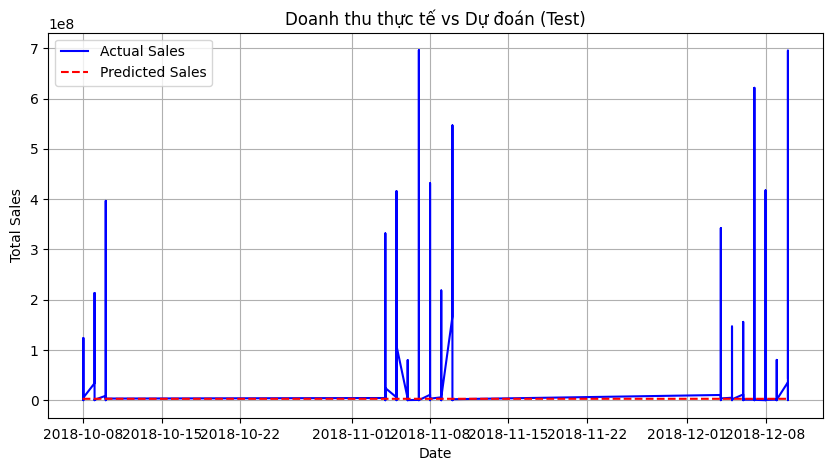

In [18]:
# Vẽ đồ thị so sánh doanh thu thực tế và dự đoán trên tập test
plt.figure(figsize=(10, 5))
plt.plot(test_sales.index, test_sales['total_sales'], label='Actual Sales', color='blue')
plt.plot(test_sales.index, test_preds, label='Predicted Sales', color='red', linestyle='--')
plt.title('Doanh thu thực tế vs Dự đoán (Test)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

Dự đoán doanh thu trong 30 ngày tiếp theo

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


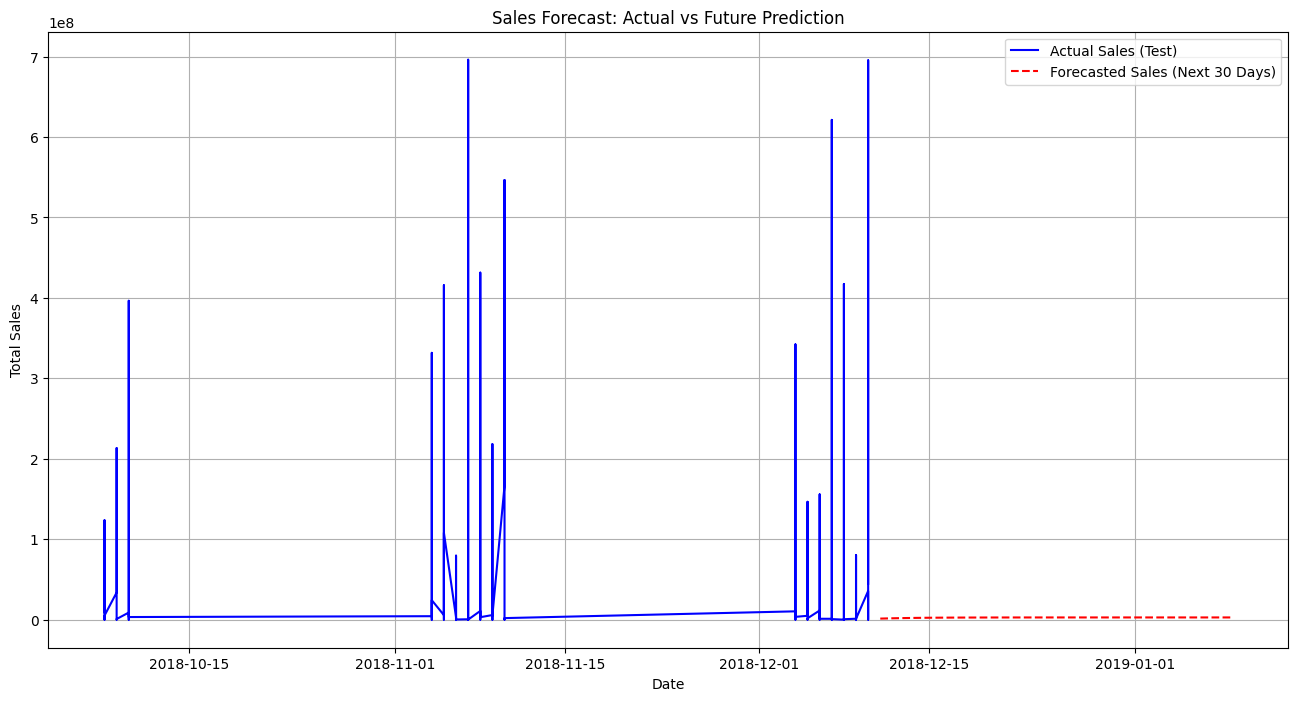

In [21]:
# Lấy ngày cuối cùng từ test_df
last_date = test_sales.index[-1]

# Tạo danh sách 30 ngày tiếp theo từ ngày cuối cùng
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30).strftime('%Y-%m-%d')

# Dự đoán doanh thu cho 30 ngày tiếp theo
future_preds = model_fit.forecast(steps=30)

# Tạo DataFrame chứa dự đoán
future_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_preds,
    'type': 'Forecasted Sales'
})

# Đảm bảo rằng 'date' trong future_df là datetime
future_df['date'] = pd.to_datetime(future_df['date'])

# Vẽ đồ thị
plt.figure(figsize=(16, 8))
plt.plot(test_sales.index, test_sales['total_sales'], label='Actual Sales (Test)', color='blue')
plt.plot(future_df['date'], future_df['total_sales'], label='Forecasted Sales (Next 30 Days)', color='red', linestyle='--')
plt.title('Sales Forecast: Actual vs Future Prediction')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


5. Vẽ biểu đồ kết quả

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


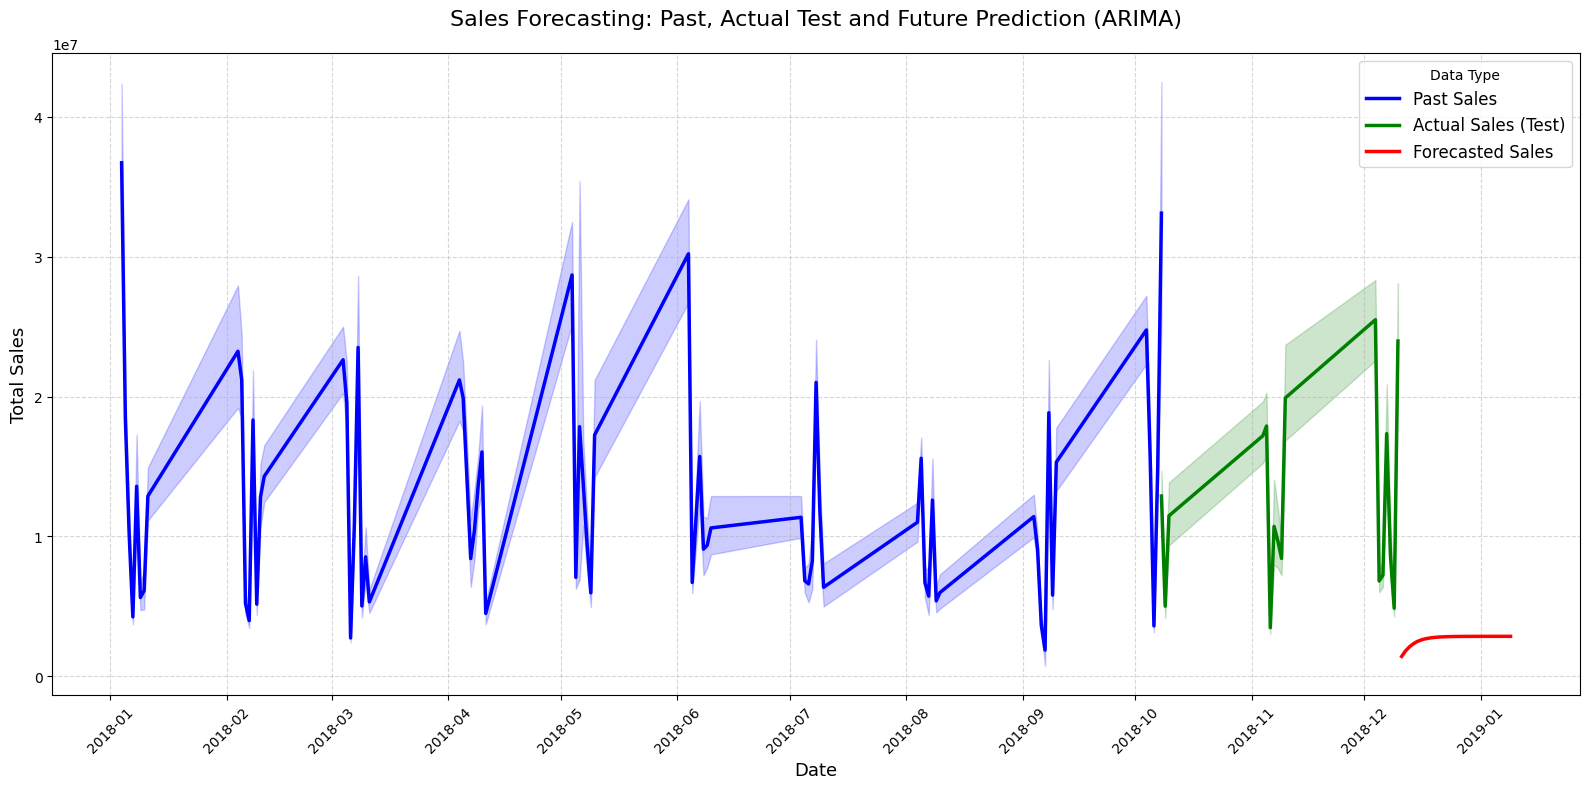

In [22]:
# Bước 7: Dự đoán 30 ngày tiếp theo
future_forecast = model_fit.forecast(steps=30)
future_dates = pd.date_range(start=end_date + timedelta(days=1), periods=30)

# Gộp để trực quan
future_df = pd.DataFrame({
    "date": future_dates,
    "total_sales": future_forecast,
    "type": "Forecasted Sales"
})
test_df['type'] = "Actual Sales (Test)"
df_all['type'] = "Past Sales"

combined_df = pd.concat([
    df_all[["date", "total_sales", "type"]],
    test_df[["date", "total_sales", "type"]],
    future_df
], ignore_index=True)

# Vẽ biểu đồ
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting: Past, Actual Test and Future Prediction (ARIMA)', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()